Libraries

In [467]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
import geopandas as gpd
import plotly.express as px

Styles

In [468]:
%matplotlib inline

In [469]:
plt.rcParams['figure.figsize'] = (20,10)

In [470]:
saved_style_state = matplotlib.rcParams.copy()

In [471]:
pd.set_option('display.max_rows', None)

Reading files...

In [472]:
ev = pd.read_csv("IEA-EV-data.csv")

In [473]:
country = pd.read_csv("countries.csv")

In [474]:
energy = pd.read_csv("energy.csv")

In [475]:
renewable_share = pd.read_csv("renewable-share-energy.csv")

Cleaning file

In [476]:
world_geo = pd.read_csv("world_geo.csv")

world_geo = world_geo.rename({'gdp_md_est': 'sales'}, axis=1)

world_geo = world_geo[(world_geo.name != 'Antarctica')]

world_geo = world_geo.drop('Unnamed: 0', axis=1)

world_geo = world_geo.replace(0, np.nan)

world_geo = world_geo.sort_values(['name'])

items_geo = []

for c in world_geo.name:
    items_geo.append(c)

items_geo.pop()

items_geo.pop()

l = len(items_geo)

world_map = world_geo

Choropleth map (total electric vehicle sales)

In [477]:
fig = px.choropleth(world_map,
    locations = 'iso_a3',
    height = 750,
    color = 'sales',
    title = 'Total Electric Vehicle Sales per Country',
    range_color = [0, 1000000],
    color_continuous_scale = 'Greens',
    
)


fig.show()

Latest sales share

In [478]:
def sales_share_latest(country):
    s = ev[(ev.region == country) & (ev.parameter == 'EV sales share') & (ev.category == 'Historical') & (ev['mode'] == 'Cars')]

    last = s.iloc[-1].value

    return last

Earliest sales share

In [479]:
def sales_share_earliest(country):
    s = ev[(ev.region == country) & (ev.parameter == 'EV sales share') & (ev.category == 'Historical') & (ev['mode'] == 'Cars')]

    first = s.iloc[-2].value

    return first

List of all recorded countries

In [480]:
country_list = []

for c in ev.region:
    if c not in country_list:
        country_list.append(c)

country_list.remove('World')
country_list.remove('Europe')
country_list.remove('Rest of the world')
country_list.remove('Other Europe')
country_list.remove('Indonesia')
country_list.remove('Thailand')

country_list[15] = 'South Korea'

country_list = sorted(country_list)

country_list[-1] = country_list[-2]
country_list[-2] = 'United Kingdom'


Sales Share Lists

In [481]:
shares_latest = []
for c in country_list:
    if c == 'South Korea':
        shares_latest.append(f"{sales_share_latest('Korea')}")
    else:
        shares_latest.append(f"{sales_share_latest(c)}")

shares_earliest = []
for c in country_list:
    if c == 'South Korea':
        shares_earliest.append(f"{sales_share_earliest('Korea')}")
    else:
        shares_earliest.append(f"{sales_share_earliest(c)}")


shares_latest = list(map(float, shares_latest))
shares_earliest = list(map(float, shares_earliest))


l = len(shares_latest)
l2 = len(shares_earliest)


New Dataframe

In [482]:
df = pd.DataFrame({'2021': shares_latest})
df1 = pd.DataFrame({'2020': shares_earliest})
df2 = pd.DataFrame({'country': country_list})

all_shares = pd.concat([df2, df1, df], axis=1)

all_shares = all_shares.sort_values('2021')


Bar plot

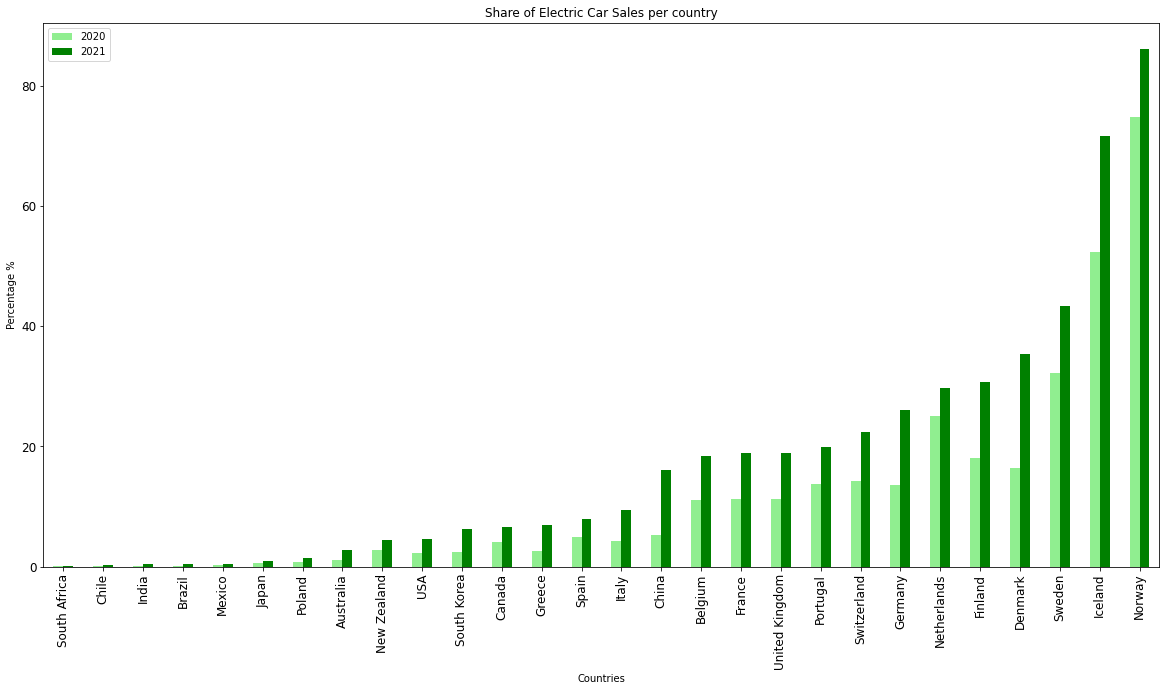

In [483]:

all_shares.plot(kind = 'bar', 
x = 'country', 
stacked = False,
title = 'Share of Electric Car Sales per country',
xlabel = 'Countries',
ylabel = 'Percentage %',
fontsize = '12',
color = {'2020': 'lightgreen','2021': 'green'}
)

plt.show()

Changing values in dataset

In [484]:
world_share = world_geo

world_share = world_share.sort_values('name')

world_share = world_share.rename(columns = {'sales': 'percentage'})

In [485]:
total_sales = []

for i in world_share.percentage:
    if i > 0:
        total_sales.append(i)

In [486]:
world_share['percentage'].replace(to_replace = total_sales, value = shares_latest, inplace = True)


Choropleth for ev sales share

In [487]:
fig2 = px.choropleth(world_share,
    locations = 'iso_a3',
    height = 750,
    color = 'percentage',
    title = 'Electric Vehicle Sales Share per Country',
    range_color = [0,90],
    color_continuous_scale = 'Greens',
    
)


fig2.show()

Investigating energy data

In [488]:
a = energy.iloc[262] 

df = pd.DataFrame(a)


In [489]:
countries = items_geo

countries.sort()

filter = energy['Country Name'].isin(countries)

filter_energy = energy[filter]

filter_e = filter_energy.sort_values(['Country Name'])

new_countries = []

for c in filter_e['Country Name']:
    new_countries.append(c)


results = []

count = 0

for i in filter_e['2019']:
    results.append(f"{i}")
    count += 1

In [490]:
world_re = world_geo

In [491]:
count = -1
index = 0

for c in world_re.name:
    count += 1
    if c in new_countries:
        world_re['sales'].iloc[count] =  results[index]
        index += 1

world_reset = world_re.reset_index()

/var/folders/kr/tpqxlsqd5012gdrwgp9860v40000gn/T/ipykernel_14193/364188295.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [492]:
world_sorted = world_reset.drop('index', axis=1)

world_sorted['sales'].iloc[165] = 10.42

world_sorted['sales'].iloc[143] = 3.36

world_sorted['sales'].iloc[130] = 3.22

/var/folders/kr/tpqxlsqd5012gdrwgp9860v40000gn/T/ipykernel_14193/173403938.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/kr/tpqxlsqd5012gdrwgp9860v40000gn/T/ipykernel_14193/173403938.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/kr/tpqxlsqd5012gdrwgp9860v40000gn/T/ipykernel_14193/173403938.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [493]:
world_sorted = world_sorted.rename(columns = {'sales': 'percentage'})

world_sorted.percentage = pd.to_numeric(world_sorted.percentage)


In [494]:
fig3 = px.choropleth(world_sorted,
    locations = 'iso_a3',
    height = 750,
    color = 'percentage',
    title = 'Renewable Energy Consumption per Country',
    range_color = [0,100],
    color_continuous_scale = 'Blues'
    
)


fig3.show()

Investigating renewable share 

In [502]:

is_21 = renewable_share['Year'] == 2021


re_21 = renewable_share[is_21]

re_21

,Entity,Code,Year,Renewables (% equivalent primary energy)
56,Africa,NaN,2021,9.555876
113,Africa (BP),NaN,2021,9.574978
170,Algeria,DZA,2021,0.261367
227,Argentina,ARG,2021,11.329249
284,Asia,NaN,2021,10.954556
341,Asia Pacific (BP),NaN,2021,12.723151
398,Australia,AUS,2021,12.933532
455,Austria,AUT,2021,37.481792
492,Azerbaijan,AZE,2021,2.201543
543,Bangladesh,BGD,2021,0.650147
